In [21]:
%pip install gdown
!pip install git+https://github.com/yidinghao/interpreting-nlp

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/yidinghao/interpreting-nlp to /tmp/pip-req-build-cly90iyc
  Running command git clone --filter=blob:none --quiet https://github.com/yidinghao/interpreting-nlp /tmp/pip-req-build-cly90iyc
  Resolved https://github.com/yidinghao/interpreting-nlp to commit b6bf81e2e52970ffe4db32cade8c9c3d48d1cd3b
  Preparing metadata (setup.py) ... done


In [22]:
train = '1HqceFWkRXwEqgPcuAtACFVvHhKO_TGG6'
val = '1XEsLOUFJTnCGcitk4IUS23H6IlzCzwqZ'
test = '1Lu5ItQvj2iGRqMXJ-bovQkys0eilR9HZ'

train_embeddings_per_word = '1-0Bb3pLy_EhEggA-VsOh8TIS92VbmmxV'
val_embeddings_per_word = '1-0WpebJIz9q2PZ_Baf51ZUsiBx9pWVJP'
test_embeddings_per_word = '1pi6DGhZ7AoGzC3cqP-ET5Qvkc3HD33bo'

train_embeddings_per_sentence = '1-260zeDhoDdxQ3McfR7Hr4c6mfaLFBpa'
val_embeddings_per_sentence = '1-2EN_l5NcdgJZ740Szt4g6RcIZ9GX_D2'
test_embeddings_per_sentence = '1gNKahNHussBAV-6mFyC66AxPTA0YhQAG'

In [23]:
!gdown {train}
!gdown {val}
!gdown {test}

!gdown {train_embeddings_per_word}
!gdown {val_embeddings_per_word}
!gdown {test_embeddings_per_word}

Downloading...
From: https://drive.google.com/uc?id=1HqceFWkRXwEqgPcuAtACFVvHhKO_TGG6
To: /kaggle/working/train_final.pkl
100%|███████████████████████████████████████| 3.47M/3.47M [00:00<00:00, 182MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XEsLOUFJTnCGcitk4IUS23H6IlzCzwqZ
To: /kaggle/working/val_final.pkl
100%|█████████████████████████████████████████| 743k/743k [00:00<00:00, 118MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Lu5ItQvj2iGRqMXJ-bovQkys0eilR9HZ
To: /kaggle/working/test_final.pkl
100%|████████████████████████████████████████| 737k/737k [00:00<00:00, 60.2MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1-0Bb3pLy_EhEggA-VsOh8TIS92VbmmxV
From (redirected): https://drive.google.com/uc?id=1-0Bb3pLy_EhEggA-VsOh8TIS92VbmmxV&confirm=t&uuid=075ef215-05ea-42c0-9576-beeb7c185cac
To: /kaggle/working/train_embeddings_per_word.pkl
100%|███████████████████████████████████████| 1.08G/1.08G [00:04<00:00, 229MB/s]
Downloading...
From (uriginal)

In [24]:
import pandas as pd
import string
import re
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.isri import ISRIStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.svm import SVC
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from interpret_nlp.modules.lrp_modules import LRPLinear, LRPGRU
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from collections import OrderedDict
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.preprocessing import OneHotEncoder
import keras_tuner

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
label_to_class = {
    0: 'none',
    1: 'anger',
    2: 'joy',
    3: 'sadness',
    4: 'love',
    5: 'sympathy',
    6: 'surprise',
    7: 'fear'
}
classes = ['none', 'anger', 'joy', 'sadness', 'love', 'sympathy', 'surprise', 'fear']

In [27]:
with open('/kaggle/working/train_final.pkl', 'rb') as f:
    train = pickle.load(f)
    
with open('/kaggle/working/val_final.pkl', 'rb') as f:
    val = pickle.load(f)

with open('/kaggle/working/test_final.pkl', 'rb') as f:
    test = pickle.load(f)

with open('/kaggle/working/train_embeddings_per_word.pkl', 'rb') as f:
    train_embeddings = pickle.load(f)
    
with open('/kaggle/working/val_embeddings_per_word.pkl', 'rb') as f:
    val_embeddings = pickle.load(f)
    
with open('/kaggle/working/test_embeddings_per_word.pkl', 'rb') as f:
    test_embeddings = pickle.load(f)

In [28]:
train.head()

,tweet,label,tweet_with_out_emojis,cleaned_data,Root Stemming,Light Stemming
5081,1996 يا مهند ياحبيبي انت تدور لبش مع اي احد ...,1,1996 يا مهند ياحبيبي انت تدور لبش مع اي احد ...,مهند ياحبيبي تدور لبش متاكد ابو جاسم مايدري,هند حبب تدر لبش تكد ابو جسم ايدر,مهند ياحبيبي تدور لبش متاكد ابو جاسم مايدري
8264,حلب عفرين اعتقال عشرات الشباب من قريه باسوطه ...,3,حلب عفرين اعتقال عشرات الشباب من قريه باسوطه ...,حلب عفرين اعتقال عشرات الشباب قريه باسوطه ريف ...,حلب عفر عقل عشر شبب قره بسط ريف عفر قوت هرب عش...,حلب عفر اعتقال عشر الشباب قريه باسوطه ريف عفر ...
9777,انا نفسي مره اجرب اكون ليك حد اقرب : ),3,انا نفسي مره اجرب اكون ليك حد اقرب : ),مره اجرب اكون ليك اقرب,مره جرب اكن ليك قرب,مره اجرب اكون ليك اقرب
740,الصراحه احساس مخزي ونحن نكتفي بالتمثيل المشرف ...,3,الصراحه احساس مخزي ونحن نكتفي بالتمثيل المشرف ...,الصراحه احساس مخزي نكتفي بالتمثيل المشرف الاول...,صرح حسس خزي كتف شرف اوليمبياد عوز صحه ريض,الصراحه احساس مخزي نكتفي بالتمثيل المشرف الاول...
6537,57 عاجل الايطالي فابيو باسل يفوز بدهب الاولي...,0,57 عاجل الايطالي فابيو باسل يفوز بدهب الاولي...,عاجل الايطالي فابيو باسل يفوز بدهب الاوليمبياد...,عجل يطل ابو بسل يفز دهب اوليمبياد جودو بطل علم...,عاجل الايطالي فابيو باسل يفوز بدهب الاوليمبياد...


In [29]:
X_train = train['Root Stemming']
y_train = train['label']
X_val = val['Root Stemming']
y_val = val['label']
X_test = test['Root Stemming']
y_test = test['label']

In [30]:
encoder = OneHotEncoder()

y_train = encoder.fit_transform(train['label'].values.reshape(-1,1)).toarray()
y_val = encoder.fit_transform(val['label'].values.reshape(-1,1)).toarray()
y_test = encoder.transform(test['label'].values.reshape(-1,1)).toarray()

In [31]:
def prepare_tokenization(train, val, test=None, pad=500):
  tokenizer = Tokenizer(oov_token='<UNK>')
  tokenizer.fit_on_texts(train)
  tokenizer.word_index['<PAD>'] = 0
  train = tokenizer.texts_to_sequences(train)
  val = tokenizer.texts_to_sequences(val)
  if not pad==False:
    train = sequence.pad_sequences(train, maxlen=pad)
    val = sequence.pad_sequences(val, maxlen=pad)
  if not type(test)==type(None):
    test = tokenizer.texts_to_sequences(test)
    if not pad==False:
      test = sequence.pad_sequences(test, maxlen=pad)
  v_size = len(tokenizer.word_index)
  print("Vocabulary size={}".format(v_size))
  print("Number of Documents={}".format(tokenizer.document_count))
  if not type(test)==type(None):
    return v_size, train, val, test
  else:
    return v_size, train, val

In [32]:
VOCAB_SIZE, train_sequences, val_sequences, test_sequences = prepare_tokenization(X_train, X_val, X_test, pad=False)

Vocabulary size=8030
Number of Documents=7045


(array([6.830e+02, 1.919e+03, 1.858e+03, 1.304e+03, 1.098e+03, 1.730e+02,
        8.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([ 0. ,  3.7,  7.4, 11.1, 14.8, 18.5, 22.2, 25.9, 29.6, 33.3, 37. ]),
 <BarContainer object of 10 artists>)

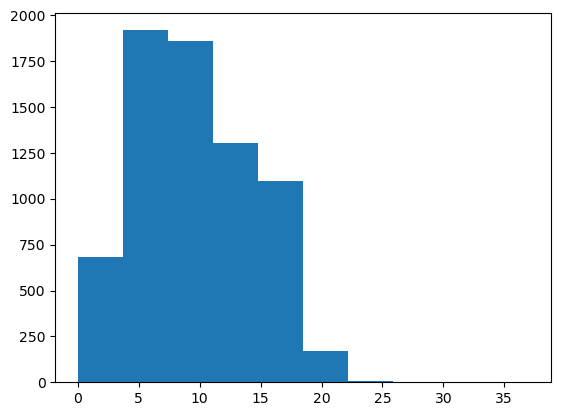

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
plt.hist(train_lens)

In [34]:
max_length = 50

In [35]:
max_length

50

In [36]:
X_train = sequence.pad_sequences(train_sequences, maxlen=max_length)
X_val = sequence.pad_sequences(val_sequences, maxlen=max_length)
X_test = sequence.pad_sequences(test_sequences, maxlen=max_length)
X_train.shape, X_val.shape, X_test.shape

((7045, 50), (1510, 50), (1510, 50))

In [66]:
BATCH_SIZE = 32
EPOCHS = 50
EMBED_SIZE = 768#86
LEARNING_RATE =  0.0053516485623658835

early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True)

In [38]:
class myDataset(Dataset):
  def __init__(self, train_sequences, labels):
      # save data
      self.train_sequences = train_sequences
      self.labels = labels

  def __getitem__(self, index):
      # retrieve data
      train_sequence = self.train_sequences[index]
      label = self.labels[index]

      return (torch.tensor(train_sequence).to(device), torch.tensor(label).to(device))

  def __len__(self):
      return len(self.labels)

In [39]:
train_set = myDataset(X_train, y_train)
val_set = myDataset(X_val, y_val)
test_set = myDataset(X_test, y_test)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [70]:
class GRU(nn.Module):
    def __init__(self):
        super(GRU, self).__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, EMBED_SIZE)
#         self.gru = nn.GRU(EMBED_SIZE, 256, num_layers=1)
        self.gru = LRPGRU(EMBED_SIZE, 256, num_layers=1)
        self.dropout = nn.Dropout(0.011691195516528197)
#         self.fc = nn.Linear(256*50, 8)
        self.fc = LRPLinear(256, 8)
        self.softmax = nn.Softmax(dim=0)
    
    def forward(self, x):
        x = self.embedding(x)
#         h0 = torch.zeros(1, max_length, 256).to(device)
#         out, _ = self.gru(x, h0)\
#         out = out.reshape(out.shape[0], -1)
        out = self.gru(x)[1][0]
        out = out.view(-1, 256)
        x = self.dropout(out)
        x = self.softmax(self.fc(x))
        return x

In [ ]:
model = GRU().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


for epoch in range(EPOCHS):
    t_acc = 0
    t_loss = 0
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        t_acc += torch.sum(torch.argmax(outputs, axis=1)==torch.argmax(labels, axis=1)).detach().cpu().numpy()
        t_loss += loss.item()
        loss.backward()
        optimizer.step()
    t_acc = t_acc/len(y_train)
    t_loss = t_loss/len(y_train)
    
    v_acc = 0
    v_loss = 0
    model.eval()
    for inputs, labels in val_loader:
        outputs = model(inputs)
        v_loss += criterion(outputs, labels).item()
        v_acc += torch.sum(torch.argmax(outputs, axis=1)==torch.argmax(labels, axis=1)).detach().cpu().numpy()
    v_acc = v_acc/len(y_val)
    v_loss = v_loss/len(y_val)
    # Print training progress
    print(f'Epoch: {epoch+1}, Train loss: {t_loss:.4f}, Train accuracy: {t_acc:.4f}, Val loss: {v_loss:.4f}, Val accuracy: {v_acc:.4f}')

Epoch: 1, Train loss: 0.0621, Train accuracy: 0.4079, Val loss: 0.0623, Val accuracy: 0.4457
Epoch: 2, Train loss: 0.0606, Train accuracy: 0.5184, Val loss: 0.0623, Val accuracy: 0.4656
Epoch: 3, Train loss: 0.0601, Train accuracy: 0.5368, Val loss: 0.0623, Val accuracy: 0.4424
Epoch: 4, Train loss: 0.0599, Train accuracy: 0.5767, Val loss: 0.0621, Val accuracy: 0.4589
Epoch: 5, Train loss: 0.0597, Train accuracy: 0.5815, Val loss: 0.0623, Val accuracy: 0.4623
Epoch: 6, Train loss: 0.0597, Train accuracy: 0.5807, Val loss: 0.0624, Val accuracy: 0.4576
Epoch: 7, Train loss: 0.0597, Train accuracy: 0.5814, Val loss: 0.0623, Val accuracy: 0.4258
Epoch: 8, Train loss: 0.0597, Train accuracy: 0.5842, Val loss: 0.0625, Val accuracy: 0.4305
Epoch: 9, Train loss: 0.0597, Train accuracy: 0.5869, Val loss: 0.0624, Val accuracy: 0.4331
Epoch: 10, Train loss: 0.0598, Train accuracy: 0.5774, Val loss: 0.0627, Val accuracy: 0.4364
Epoch: 11, Train loss: 0.0598, Train accuracy: 0.5649, Val loss: 0.06

In [ ]:
predictions = model(X_test)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=classes))